In [1]:
import blobulator
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
from matplotlib.colors import ListedColormap
colors = ["orange", "green", "blue"]
newcmap = ListedColormap(colors)

import pandas as pd
import seaborn as sns

In [5]:
def PofX(x, vec):
    return np.sum(vec==x)/len(vec)

def entropy(series, blobVals=[0.2, 0.4, 0.6]):
    sum = 0
    for x in blobVals:
        Px = PofX(x, series)
        if Px>0:
            sum -= Px*np.log(Px)
    return sum

def doHgram(sequence, Lmin=1, hscale="kyte_doolittle"):
    hydropathygram = []
    
    Hvals = np.linspace(0,1, 100)
    for H in Hvals:
        blobDF = blobulator.compute(sequence, H, Lmin, hscale)
        blobs = blobDF.domain_to_numbers.values
        hydropathygram.append(blobs)

    return hydropathygram, Hvals

def getEntropies(gram, blobVals = [0.2, 0.4, 0.6]):
    entropies = []
    for blobulation in gram:
        entropies.append(entropy(blobulation))
        
    return entropies

def doLmingram(sequence, H=0.4, hscale="kyte_doolittle"):
    lmingram = []
    
    Lminvals = range(len(sequence))
    for Lmin in Lminvals:
        blobDF = blobulator.compute(sequence, H, Lmin, hscale)
        blobs = blobDF.domain_to_numbers.values
        lmingram.append(blobs)
        if np.all(blobs<0.4):
            break

    return lmingram, Lminvals

In [6]:
# A very simple oligopeptide
ELIC = "APADNAADARPVDVSVSIFINKIYGVNTLEQTYKVDGYIVAQWTGKPRKTPGDKPLIVENTQIERWINNGLWVPALEFINVVGSPDTGNKRLMLFPDGRVIYNARFLGSFSNDMDFRLFPFDRQQFVLELEPFSYNNQQLRFSDIQVYTENIDNEEIDEWWIRGKASTHISDIRYDHLSSVQPNQNEFSRITVRIDAVRNPSYYLWSFILPLGLIIAASWSVFWLESFSERLQTSFTLMLTVVAYAFYTSNILPRLPYTTVIDQMIIAGYGSIFAAILLIIFAHHRQANGVEDDLLIQRCRLAFPLGFLAIGCVLVIRGITL"
asynuclein = "MDVFMKGLSKAKEGVVAAAEKTKQGVAEAAGKTKEGVLYVGSKTKEGVVHGVATVAEKTKEQVTNVGGAVVTGVTAVAQKTVEGAGSIAAATGFVKKDQLGKNEEGAPQEGILEDMPVDPDNEAYEMPSEEGYQDYEPEA"

sequence = ELIC
# Default cutoff, Lmin, and hydrophobicity scale
cutoff = 0.4
min_blob = 4
hscale = "kyte_doolittle"


# Scan hydropathy cutoff values

In [7]:
hydropathygram, Hvals = doHgram(sequence, Lmin=4)
Hentropies = getEntropies(hydropathygram)

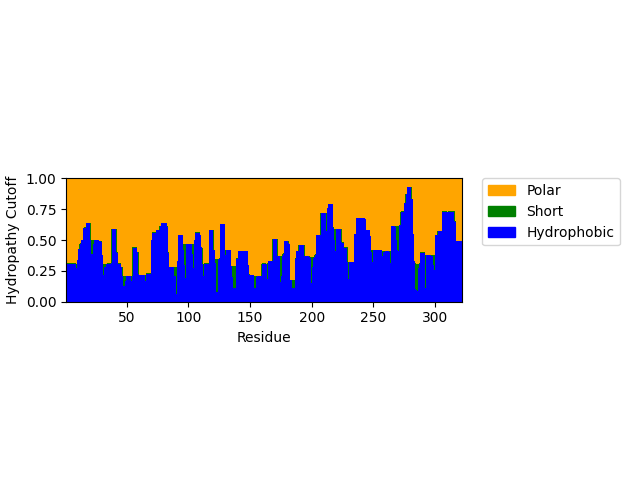

In [8]:
%matplotlib widget
plt.figure()
im = plt.imshow(hydropathygram, cmap=newcmap, interpolation=None, extent=(1,len(sequence), 0,1), origin='lower', aspect=100)

plt.xlabel("Residue")
plt.xlim((1,len(sequence)))
plt.ylabel("Hydropathy Cutoff")

blbs = ['Polar', 'Short', 'Hydrophobic']
patches = [ mpatches.Patch(color=clr, label=blb ) for clr, blb in zip(colors,blbs) ]
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )

plt.tight_layout()
plt.show()
plt.savefig("Vary_Hydropathy_cutoff.pdf")

%matplotlib widget
fig, ax = plt.subplots()
plt.plot(Hvals, Hentropies)

Hmax = Hvals[np.argmax(Hentropies)]
ax.axvline(Hmax, linestyle="--", color="gray", label=np.round(Hmax,2))

plt.legend()
plt.tight_layout()
plt.show()
plt.savefig("Vary_Hydropathy_entropies.pdf")

# Scan Lmin values

In [9]:
lmingram, Lvals = doLmingram(sequence, H=0.4)
Lentropies = getEntropies(lmingram)

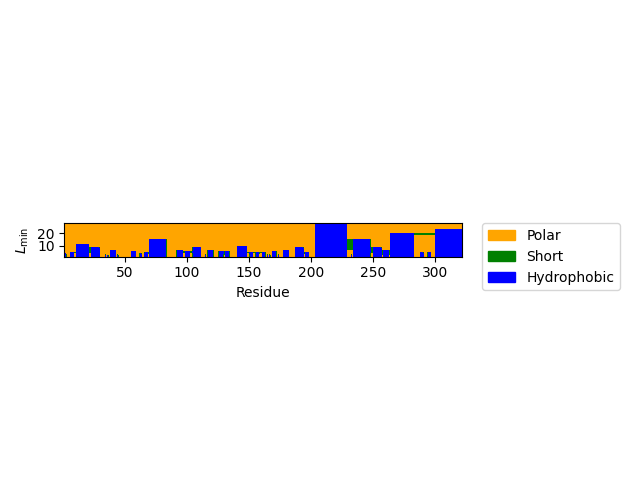

In [10]:
%matplotlib widget
im = plt.imshow(lmingram, cmap=newcmap, interpolation=None, origin='lower', aspect=1, extent=(1,len(sequence), 1, len(lmingram)))

plt.xlabel("Residue")
plt.ylabel(r"$L_\mathrm{min}$")
plt.xlim((1,len(sequence)))
blbs = ['Polar', 'Short', 'Hydrophobic']
patches = [ mpatches.Patch(color=clr, label=blb ) for clr, blb in zip(colors,blbs) ]
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )
plt.tight_layout()

plt.savefig("Vary_Lmin.pdf")
plt.show()

%matplotlib widget
fig, ax = plt.subplots()
plt.plot(Lvals, Lentropies)

Lmax = Lvals[np.argmax(Lentropies)]
ax.axvline(Lmax, linestyle="--", color="gray", label=np.round(Lmax,2))

plt.legend()
plt.tight_layout()
plt.show()
plt.savefig("Vary_Hydropathy_entropies.pdf")

# Simultaneously

In [11]:
from tqdm import tqdm
Hvals = np.linspace(0,1,100)

data = []
for H in tqdm(Hvals):
    lgram, Lvals = doLmingram(sequence, H=H)
    Es = getEntropies(lgram)
    data.extend(list(zip(Lvals, np.repeat(H, len(Es)), Es)))


100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [11:47<00:00,  7.08s/it]


/tmp/ipykernel_4566/2679507512.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  pivotted= df.pivot('Lmin','H','Entropy')


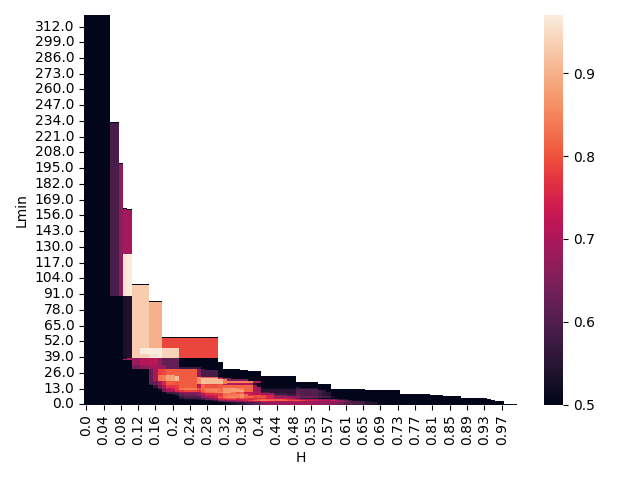

In [13]:

rounded = np.round(data, 2)
df = pd.DataFrame(rounded, columns = ['Lmin', 'H', 'Entropy'])
pivotted= df.pivot('Lmin','H','Entropy')



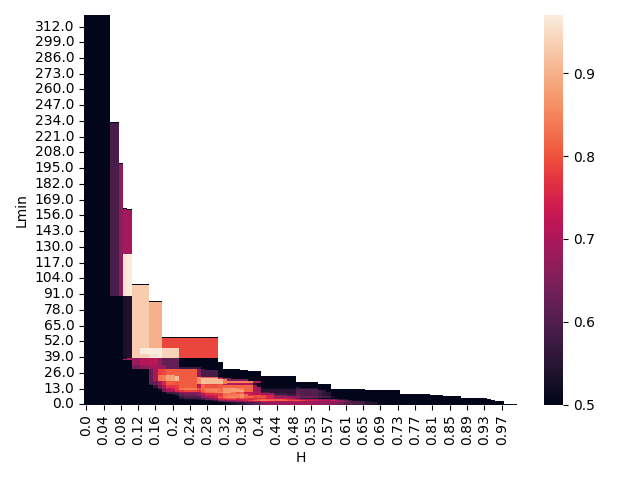

In [14]:
%matplotlib widget
ax = sns.heatmap(pivotted, vmin=0.5)
ax.invert_yaxis()
plt.tight_layout()


plt.savefig("Shannon_Entropy.pdf")
plt.show()